<a href="https://colab.research.google.com/github/InKyuHwang001/Kaggle/blob/master/PFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
import itertools
import gc
import pickle
from xgboost import XGBRegressor
from xgboost import plot_importance

%matplotlib inline

# Load Data

In [2]:
df_train = pd.read_csv('/content/drive/MyDrive/data/kaggle/competitive-data-science-predict-future-sales/sales_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/kaggle/competitive-data-science-predict-future-sales/test.csv')
df_items = pd.read_csv('/content/drive/MyDrive/data/kaggle/competitive-data-science-predict-future-sales/items.csv')
df_item_categories = pd.read_csv('/content/drive/MyDrive/data/kaggle/competitive-data-science-predict-future-sales/item_categories.csv')
df_shops = pd.read_csv('/content/drive/MyDrive/data/kaggle/competitive-data-science-predict-future-sales/shops.csv')

In [3]:
df_train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [4]:
df_train.tail(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [5]:
df_test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [6]:
df_items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [7]:
df_shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


# Preliminary Wrangling


## 어디서나 사용되는 것

### 중복 체크


In [9]:
sum(df_train.duplicated()), sum(df_test.duplicated())

(6, 0)

In [10]:
sum(df_items.duplicated()), sum(df_item_categories.duplicated()), sum(df_shops.duplicated())

(0, 0, 0)

df_train에만 중복 행이 6개 있음

In [11]:
df_train[df_train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [12]:
# 중복 제거
df_train.drop_duplicates(inplace=True)

# 중복 재확인
sum(df_train.duplicated())

0

### Null 

In [13]:
df_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [14]:
df_test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

### Outlier 제거

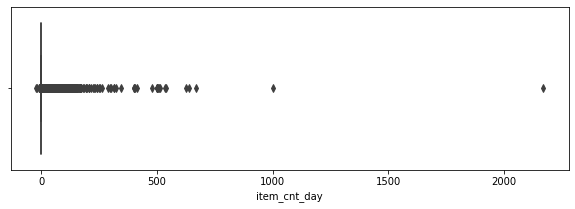

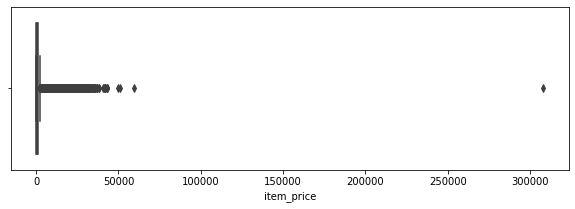

In [15]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train);

item_cnt_day 500이상, item_price 50,000 이상의 Outlier 제거

In [16]:
df_train = df_train[df_train.item_cnt_day < 500]
df_train = df_train[df_train.item_price < 50000]

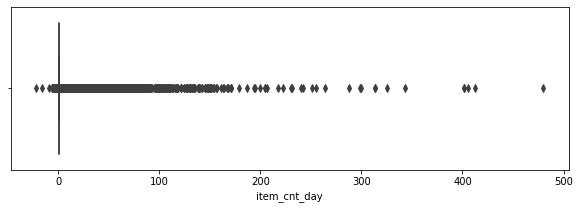

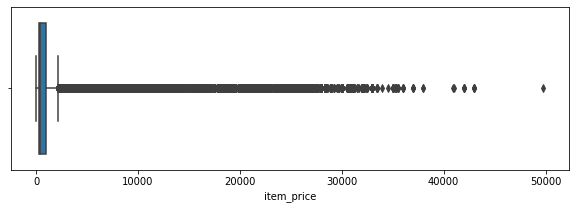

In [17]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train);

In [18]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935826e+06,2.935826e+06,2.935826e+06,2.935826e+06,2.935826e+06
mean,1.456986e+01,3.300178e+01,1.019721e+04,8.907121e+02,1.239344e+00
std,9.422973e+00,1.622696e+01,6.324294e+03,1.719911e+03,1.923299e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,4.978200e+04,4.800000e+02


In [19]:
df_train = df_train[df_train.item_cnt_day >= 0]
df_train = df_train[df_train.item_price >= 0]

## Shops name 수정


In [20]:
df_shops.head(2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [21]:
df_shops.loc[df_shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [22]:
 df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])

In [23]:
df_shops.head(2)

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск


In [24]:
df_shops.loc[df_shops.city == '!Якутск', 'city'] = 'Якутск'

수치 데이터가 아닌 문자 데이터는 데이터 분석이 번거롭다. 따라서 문자 데이터를 모두 수치 데이터로 Encoding하는 작업이 필요하다.

## df_shops Enconding


In [25]:
df_shops.city.value_counts()

Москва              13
Якутск               4
РостовНаДону         3
Воронеж              3
Тюмень               3
Новосибирск          2
Н.Новгород           2
Самара               2
Красноярск           2
Казань               2
Жуковский            2
Уфа                  2
СПб                  2
Томск                1
Сургут               1
СергиевПосад         1
Химки                1
Цифровой             1
Чехов                1
Мытищи               1
Омск                 1
Адыгея               1
Курск                1
Коломна              1
Калуга               1
Интернет-магазин     1
Выездная             1
Вологда              1
Волжский             1
Балашиха             1
Ярославль            1
Name: city, dtype: int64

In [26]:
city_encoder = LabelEncoder()
df_shops['city_code'] = city_encoder.fit_transform(df_shops['city'])
df_shops = df_shops[['shop_id', 'city_code']]
df_shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


## Item category Encoding

In [27]:
df_item_categories.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [28]:
type_encoder = LabelEncoder()
df_item_categories['split_name'] = df_item_categories['item_category_name'].str.split(' - ')
df_item_categories['type'] = df_item_categories['split_name'].map(lambda x: x[0].strip())
df_item_categories['type_code'] = type_encoder.fit_transform(df_item_categories['type'])

In [29]:
df_item_categories.head(2)

,item_category_name,item_category_id,split_name,type,type_code
0,PC - Гарнитуры/Наушники,0,"[PC, Гарнитуры/Наушники]",PC,0
1,Аксессуары - PS2,1,"[Аксессуары, PS2]",Аксессуары,1


In [30]:
subtype_encoder = LabelEncoder()
df_item_categories['subtype'] = df_item_categories['split_name'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_item_categories['subtype_code'] = subtype_encoder.fit_transform(df_item_categories['subtype'])
df_item_categories = df_item_categories[['item_category_id', 'type_code', 'subtype_code']]

In [31]:
df_item_categories.head(2)

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11


## Item Encoding

이미 item_id와 item_category_id가 숫자로 매핑되어 있어 name만 drop해주면 됨



In [32]:
df_items.head(2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [33]:
df_items.drop(['item_name'], axis=1, inplace=True)
df_items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


Encoding된 shops, category, item

In [34]:
df_shops.head(2)

,shop_id,city_code
0,0,29
1,1,29


In [35]:
df_item_categories.head(2)

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11


In [36]:
df_items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


## df_test shop_id, item_id

In [37]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [38]:
df_test.shop_id.value_counts()

5     5100
56    5100
53    5100
52    5100
47    5100
48    5100
57    5100
58    5100
59    5100
55    5100
36    5100
4     5100
37    5100
35    5100
38    5100
34    5100
46    5100
41    5100
44    5100
39    5100
49    5100
50    5100
42    5100
19    5100
6     5100
3     5100
2     5100
7     5100
10    5100
12    5100
28    5100
31    5100
26    5100
25    5100
22    5100
24    5100
21    5100
15    5100
16    5100
18    5100
14    5100
45    5100
Name: shop_id, dtype: int64

In [39]:
len(df_test.shop_id.unique())

42

총 42개의 shop_id가 있으며 각 shop_id마다 5,100개의 item이 있다.



In [40]:
len(set(df_test.item_id) - set(df_train.item_id))

363

df_test에는 있지만 df_train에는 없는 item_id가 총 363개 있다. 이는 df_train에 모든 종류의 item이 있지는 않다는 것을 뜻한다. 363개의 item에 대해서는 0개가 판매된 것으로 예측해야한다.

In [41]:
len(df_test) == 42*5100

True

42개의 shop_id, 5,100개의 item이 있으므로 df_test에는 총 42*5100 = 214,200개의 row가 있다

## 'date_block_num', 'shop_id', 'item_id'로 구성된 Matrix 만들기

In [42]:
num_date_block_num = len(df_train.date_block_num.value_counts())
num_date_block_num

34

In [43]:
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = df_train[df_train.date_block_num == i]
    matrix.append(np.array(list(itertools.product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)

In [44]:
matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


## df_train의 Groupby를 통한 Monthly Sales 구하기


df_train에 revenue를 추가한다

In [45]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0


In [46]:
df_train['revenue'] = df_train['item_price'] * df_train['item_cnt_day']
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,349.00


df_train의 Groupby

In [47]:
group = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
group.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              0       32               6.0
                       33               3.0
                       35               1.0
                       43               1.0
                       51               2.0

In [48]:
group.columns = ['item_cnt_month']
group.head()

item_cnt_month
date_block_num shop_id item_id                
0              0       32                  6.0
                       33                  3.0
                       35                  1.0
                       43                  1.0
                       51                  2.0

In [49]:
group.reset_index(inplace=True)
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


marix와 group을 merge한다



In [50]:
matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


In [51]:
matrix = pd.merge(matrix, group, how='left')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,NaN
1,0,0,27,NaN
2,0,0,28,NaN
3,0,0,29,NaN
4,0,0,32,6.0


In [52]:
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0, 30).astype(np.float16))
# NaN은 0으로 바꾸고, 범위를 0과 30사이로 정한다. 30이 넘어가는 수는 그다지 많지 않기 때문에 예측의 정확성을 위해 범위를 지정해준다. 타입도 float16으로 바꾼다.

In [53]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


이제 matrx에는 모든 date_block_num, shop_id, tiem_id에 따른 월별 판매량이 저장되어 있다.

## Matrix에 테스트 데이터 붙이기


In [54]:
df_test.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [55]:
df_test['date_block_num'] = 34
df_test['date_block_num'] = df_test['date_block_num'].astype(np.int8)
df_test['shop_id'] = df_test['shop_id'].astype(np.int8)
df_test['item_id'] = df_test['item_id'].astype(np.int16)

df_test.head(2)

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34


In [56]:
matrix = pd.concat([matrix, df_test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # for 34 month
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,0,19,0.0,0.0
1,0,0,27,0.0,0.0
2,0,0,28,0.0,0.0
3,0,0,29,0.0,0.0
4,0,0,32,6.0,0.0


In [57]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID
11098655,34,45,18454,0.0,214195.0
11098656,34,45,16188,0.0,214196.0
11098657,34,45,15757,0.0,214197.0
11098658,34,45,19648,0.0,214198.0
11098659,34,45,969,0.0,214199.0


## matrix에 df_shops, df_items, df_item_categories merge하기

겹치는 column을 기준으로 df_shops, df_items, df_item_categories를 matrix에 merge시킨다

In [58]:
matrix = pd.merge(matrix, df_shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, df_items, on=['item_id'], how='left')
matrix = pd.merge(matrix, df_item_categories, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.0,0.0,29,40,11,6
1,0,0,27,0.0,0.0,29,19,5,12
2,0,0,28,0.0,0.0,29,30,8,57
3,0,0,29,0.0,0.0,29,23,5,18
4,0,0,32,6.0,0.0,29,40,11,6


In [59]:
matrix[matrix['date_block_num'] == 0]

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.0,0.0,29,40,11,6
1,0,0,27,0.0,0.0,29,19,5,12
2,0,0,28,0.0,0.0,29,30,8,57
3,0,0,29,0.0,0.0,29,23,5,18
4,0,0,32,6.0,0.0,29,40,11,6
...,...,...,...,...,...,...,...,...,...
364945,0,59,22149,0.0,0.0,30,40,11,6
364946,0,59,22151,2.0,0.0,30,40,11,6
364947,0,59,22154,1.0,0.0,30,37,11,1
364948,0,59,22160,0.0,0.0,30,40,11,6


## Matrix에 Target lags 추가


item_cnt_month_i는 i달 전의 동일 shop, 동일 제품의 판매량을 말한다.

In [60]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

## Mean encoded features


In [61]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']
group.head()

,date_avg_item_cnt
date_block_num,
0,0.354980
1,0.333008
2,0.367432
3,0.287354
4,0.270996


In [62]:
group.reset_index(inplace=True)
group.head()

,date_block_num,date_avg_item_cnt
0,0,0.354980
1,1,0.333008
2,2,0.367432
3,3,0.287354
4,4,0.270996


matrix에 월 평균 판매 수량 (date_avg_item_cnt) 추가하기

In [63]:
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt
0,0,0,19,0.0,0.0,29,40,11,6,NaN,NaN,NaN,NaN,NaN,0.35498
1,0,0,27,0.0,0.0,29,19,5,12,NaN,NaN,NaN,NaN,NaN,0.35498
2,0,0,28,0.0,0.0,29,30,8,57,NaN,NaN,NaN,NaN,NaN,0.35498
3,0,0,29,0.0,0.0,29,23,5,18,NaN,NaN,NaN,NaN,NaN,0.35498
4,0,0,32,6.0,0.0,29,40,11,6,NaN,NaN,NaN,NaN,NaN,0.35498


matrix에 월 평균 판매 수량에 대한 1달 lag 추가하기



In [64]:
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt,date_avg_item_cnt_lag_1
11098655,34,45,18454,0.0,214195.0,20,55,13,4,1.0,0.0,0.0,0.0,NaN,0.0,0.266846
11098656,34,45,16188,0.0,214196.0,20,64,14,44,0.0,0.0,NaN,NaN,NaN,0.0,0.266846
11098657,34,45,15757,0.0,214197.0,20,55,13,4,0.0,0.0,0.0,0.0,0.0,0.0,0.266846
11098658,34,45,19648,0.0,214198.0,20,40,11,6,0.0,0.0,0.0,0.0,NaN,0.0,0.266846
11098659,34,45,969,0.0,214199.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.266846


In [65]:
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
11098655,34,45,18454,0.0,214195.0,20,55,13,4,1.0,0.0,0.0,0.0,NaN,0.266846
11098656,34,45,16188,0.0,214196.0,20,64,14,44,0.0,0.0,NaN,NaN,NaN,0.266846
11098657,34,45,15757,0.0,214197.0,20,55,13,4,0.0,0.0,0.0,0.0,0.0,0.266846
11098658,34,45,19648,0.0,214198.0,20,40,11,6,0.0,0.0,0.0,0.0,NaN,0.266846
11098659,34,45,969,0.0,214199.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0,0.266846


## 여러가지 조합으로 lag 추가하기

matrix에 월별 item별 평균 판매 수량(date_item_avg_item_cnt) lag 추가하기

In [66]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별, shop_id별 평균 판매 수량(date_shop_avg_item_cnt) lag 추가하기



In [67]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 category별 평균 판매 수량(date_cat_avg_item_cnt) lag 추가하기



In [68]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 shop별, category별 평균 판매 수량(date_shop_cat_avg_item_cnt) lag 추가하기

In [69]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 shop별, type_code별 평균 판매 수량(date_shop_type_avg_item_cnt) lag 추가하기

In [70]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 shop별, subtype_code별 평균 판매 수량(date_shop_subtype_avg_item_cnt) lag 추가하기

In [71]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 city_code별 평균 판매 수량(date_city_avg_item_cnt) lag 추가하기



In [72]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 item별, city_code별 평균 판매 수량(date_item_city_avg_item_cnt) lag 추가하기

In [73]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 type_code별 평균 판매 수량(date_type_avg_item_cnt) lag 추가하기



In [74]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

matrix에 월별 subtype_code별 평균 판매 수량(date_subtype_avg_item_cnt) lag 추가하기



In [75]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

## Trend Features


지난 6개월 간의 가격 변동폭을 살펴본다



Matrix에 item_id별 평균 가격 추가

In [76]:
group = df_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

Matrix에 월별 item_id별 평균 가격 추가



In [77]:
group = df_train.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

Matrix에 해당 월별 item_id별 평균 가격이 어떤 가격 트렌드를 가지고 있는지 (delta_price_lag) 구하기



In [78]:
lags = [1, 2, 3, 4, 5, 6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')
for lag in lags:
    matrix['delta_price_lag_'+str(lag)] = \
    (matrix['date_item_avg_item_price_lag_'+str(lag)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']
def select_trend(row):
    for lag in lags:
        if row['delta_price_lag_'+str(lag)]:
            return row['delta_price_lag_'+str(lag)]
    return 0
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

delta_price_lag를 구했으므로 필요없는 feature는 drop

In [79]:
features_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    features_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    features_to_drop += ['delta_price_lag_'+str(i)]
matrix.drop(features_to_drop, axis=1, inplace=True)

shop revenue trend를 살펴본다



In [80]:
group = df_train.groupby(['date_block_num', 'shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue', 'shop_avg_revenue', 'delta_revenue'], axis=1, inplace=True)

## Special Features
date_block_num를 기반으로 month를 도출한다

In [81]:
matrix['month'] = matrix['date_block_num'] % 12

월별 일수를 matrix에 추가한다

In [82]:
days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days
0,0,0,19,0.0,0.0,29,40,11,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
1,0,0,27,0.0,0.0,29,19,5,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
2,0,0,28,0.0,0.0,29,30,8,57,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
3,0,0,29,0.0,0.0,29,23,5,18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
4,0,0,32,6.0,0.0,29,40,11,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31


마지막 판매가 있고 나서부터 지난 개월 수 (shop-item pair별, item별)



In [83]:
# shop-item pari별
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)

for index, row in matrix.iterrows():
    key = str(row.item_id) + ' ' + str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[index, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num
# item별
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)

for index, row in matrix.iterrows():
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            matrix.at[index, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num

첫번째 판매 후 지난 개월 수 (shop-item pair, item pair 별)



In [84]:
matrix.groupby(['item_id','shop_id'])['date_block_num']

In [85]:
matrix['date_block_num'] - matrix.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')

0            0
1            0
2            0
3            0
4            0
            ..
11098655    11
11098656     2
11098657    34
11098658    11
11098659    17
Name: date_block_num, Length: 11098660, dtype: int8

In [86]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
0,0,0,19,0.0,0.0,29,40,11,6,NaN,...,NaN,NaN,0.0,NaN,0,31,-1,-1,0,0
1,0,0,27,0.0,0.0,29,19,5,12,NaN,...,NaN,NaN,0.0,NaN,0,31,-1,-1,0,0
2,0,0,28,0.0,0.0,29,30,8,57,NaN,...,NaN,NaN,0.0,NaN,0,31,-1,-1,0,0
3,0,0,29,0.0,0.0,29,23,5,18,NaN,...,NaN,NaN,0.0,NaN,0,31,-1,-1,0,0
4,0,0,32,6.0,0.0,29,40,11,6,NaN,...,NaN,NaN,0.0,NaN,0,31,-1,-1,0,0


## Final preparations
lag를 12까지 사용했으므로 첫 12달은 drop한다

In [87]:
matrix = matrix[matrix.date_block_num > 11]
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
    return df

matrix = fill_na(matrix)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [88]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'city_code', 'item_category_id', 'type_code', 'subtype_code',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       

In [89]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6619816 entries, 4478844 to 11098659
Data columns (total 41 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   ID                                    float64
 5   city_code                             int8   
 6   item_category_id                      int8   
 7   type_code                             int8   
 8   subtype_code                          int8   
 9   item_cnt_month_lag_1                  float16
 10  item_cnt_month_lag_2                  float16
 11  item_cnt_month_lag_3                  float16
 12  item_cnt_month_lag_6                  float16
 13  item_cnt_month_lag_12                 float16
 14  date_avg_item_cnt_lag_1               float16
 15  date_ite

In [89]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del df_items
del df_shops
del df_item_categories
del df_train
# 가비지 콜렉팅
gc.collect();

# Prediction: xgboost

In [90]:
data = pd.read_pickle('data.pkl')

FileNotFoundError: ignored

In [ ]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

date_block_num 13~32까지는 훈련 데이터, 33은 검증 데이터, 34는 테스트 데이터



In [ ]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

del data
gc.collect();

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

## Submission file



In [ ]:
submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

## Plot Feature importance

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,14))
plot_importance(model, ax=ax)